##### Preamble/Imports

In [2]:
import matplotlib
matplotlib.use( "agg" )
%pylab inline

import plt_fmt

from numba import jit

Populating the interactive namespace from numpy and matplotlib


/Users/william/miniconda/envs/spakenv/lib/python3.4/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# One-dimensional square well

In [3]:
# even faster if I pass the laplacian as a parameter

@jit
def lap2d(npts):
    op = zeros([npts, npts])
    a = -2*ones((1, npts))[0]
    b = ones((1, npts-1))[0]
    op = diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    op[0,1] = 2
    op[-1,-2] = 2
    return op

@jit
def grad1D(npts):
    op = zeros([npts, npts])
    a = zeros((1, npts))[0]
    b = .5*ones((1, npts-1))[0]
    op = diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    op[0,0] = .5
    op[-1,-1] = .5
    return op

@jit
def nxt_step(yvals, time, dt, dx):
    """
    return the derivative for the square well diffusion equation
    """
    alpha = 1.0
    
    Dc = alpha*(time**(alpha-1))*.06
    kd = 40
    
    L = len(yvals)
        
    nxt_vals = zeros(len(yvals))
    
    # diffusive step
    lap = lap2d(L) 
    nxt_vals += Dc*(1/dx**2)*lap.dot(yvals)
    
    drain_window = zeros(L)
    drain_window[ floor(L/2 - L/6):floor(L/2 + L/6) ] = 1.0
    
    nxt_vals += -kd*drain_window*yvals
    
    nxt_vals[0] = nxt_vals[1]
    nxt_vals[-1] = nxt_vals[-2]
    
    return nxt_vals

space_pts = 100
actual_length = 1.0
dx = actual_length/space_pts

time_pts = 100000
actual_time = .5
dt = actual_time/time_pts

y0 = ones(space_pts)
# y0 = zeros(space_pts)
# y0[45:65] = 1.0

def euler_mesh(yinit, ynxt, start, stop, dt, other_args):
    """
    ynxt : function
        The function that computes the next step in the forward march
    
    dt : double
        The spatial step
        
    dx : double
        The time step size
    """
    times = linspace(start, stop, ceil((stop-start)/dt))
    solmesh = zeros([len(yinit), len(times)])
    solmesh[:,0] = yinit
    tL = len(solmesh[0,:])
    for tind in range(tL):
        if tind > 0 and tind < tL:
            solmesh[:,tind] = solmesh[:,tind-1] + dt*ynxt( solmesh[:,tind-1], times[tind], dt, *other_args)
    return solmesh

sol = euler_mesh(y0, nxt_step, 0.0, actual_time, dt, [dx])
print ("Done")

Done


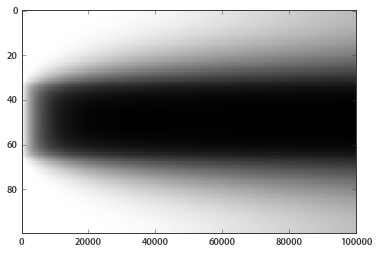

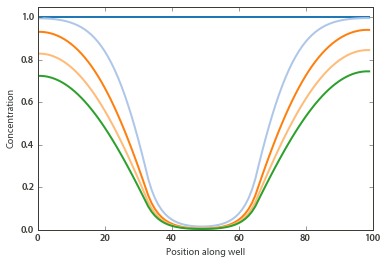

/Users/william/miniconda/envs/spakenv/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['MyriadmPro'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


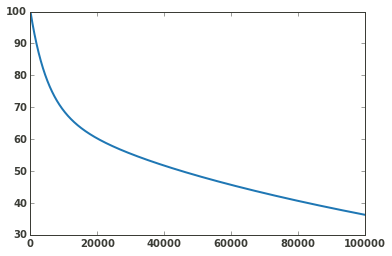

In [4]:
figure()
imshow(sol, aspect='auto')

figure()
plot(sol[:,0])
hold(True)
plot(sol[:,25000])
plot(sol[:,50000])
plot(sol[:,75000])
plot(sol[:,-1])
ylim([0,1.05])
rcParams['font.family']='MyriadmPro'
xlabel("Position along well")
ylabel("Concentration")
# savefig('xxSquare_well_alpha_1.pdf')


figure()
total_conc = sum(sol, axis = 0)
plot(total_conc)

/Users/william/miniconda/envs/spakenv/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['MyriadmPro'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


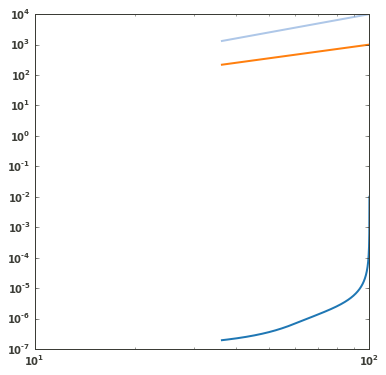

In [18]:
loglog(total_conc, 1/cumsum(total_conc))
# hold(True)
# loglog(total_conc,total_conc**2)
# loglog(total_conc,total_conc**1.5)